In [1]:
import asyncio
import json
import logging
import random
import sys
from datetime import datetime, timedelta

import pandas as pd
import pytz
from telethon.sync import TelegramClient
from telethon.tl.functions.messages import GetHistoryRequest

In [2]:
utc = pytz.UTC
logger = logging.getLogger()


def init_logger():
    logger.setLevel(logging.INFO)
    formatter = logging.Formatter('%(asctime)s | %(levelname)s\t| %(message)s')
    ch = logging.StreamHandler(sys.stdout)
    ch.setFormatter(formatter)
    logger.addHandler(ch)


init_logger()

В качестве источника был выбран телеграм-канал новостей Formula1

In [3]:
class MessageParser:
    def __init__(self, api_id, api_hash, phone, link):
        self.api_id = api_id
        self.api_hash = api_hash
        self.phone = phone
        self.link = link
        self.channel = None

        self.client = TelegramClient(phone, api_id, api_hash)
        self.client.start()

    async def init_client(self):
        await self.client.connect()
        self.channel = await self.client.get_entity(self.link)
        return self.channel

    @classmethod
    def get_text(cls, block: dict) -> str:
        text = None
        if 'text' in block:
            text = block.get('text')
        if 'texts' in block:
            text = block.get('texts')
        if text is None:
            return ''
        if isinstance(text, str):
            return text
        if isinstance(text, dict):
            return cls.get_text(text)
        if isinstance(text, list):
            data = [cls.get_text(x) for x in text]
            return ' '.join(data)
        return ''

    async def get_messages(self, date_from: datetime):
        all_messages = []
        offset_id = 0
        limit = 100
        target_date = datetime.now(tz=utc)

        while date_from < target_date:
            history = await self.client(GetHistoryRequest(
                peer=self.channel,
                offset_id=offset_id,
                offset_date=None,
                add_offset=0,
                limit=limit,
                max_id=0,
                min_id=0,
                hash=0
            ))
            if not history.messages:
                break
            target_date = min(list(map(lambda x: x.date, history.messages)))
            messages = list(filter(lambda x: x.date >= date_from, history.messages))
            for message in messages:
                all_messages.append(message.to_dict())
            offset_id = messages[len(messages) - 1].id
            logger.info(f'parsed {len(messages)} messages till {target_date.strftime("%d.%m.%Y")}')
            await asyncio.sleep(random.randint(200, 2000) / 1000)
        return all_messages

    def parse_message(self, message):
        media = message.get('media') or {}
        views = message.get('views')
        if isinstance(media, str):
            media = media.replace("'", '"')
            media = json.loads(media)
        webpage = media.get('webpage') or {}
        cached_page = webpage.get('cached_page') or {}
        blocks = cached_page.get('blocks') or []
        title = ' '.join([self.get_text(x) for x in blocks if x['_'] == 'PageBlockTitle'])
        data = ' '.join([self.get_text(x) for x in blocks if x['_'] == 'PageBlockParagraph'])
        date = message['date'].isoformat()
        return {'title': title, 'text': data, 'date': date, 'views': views}

    async def close(self):
        return await self.client.disconnect()

    async def __aenter__(self):
        await self.init_client()
        return self

    async def __aexit__(self, exc_type, exc_val, exc_tb):
        await self.close()

In [5]:
async with MessageParser(
        api_id=...,
        api_hash='...',
        phone='...',
        link='https://t.me/formula_1_news'
) as parser:
    date_from = datetime.now(tz=utc) - timedelta(days=30)
    all_messages = await parser.get_messages(date_from)

    msg_data = []
    for message in all_messages:
        data = parser.parse_message(message)
        msg_data.append(data)
    with open('messages.json', 'w+') as outfile:
        json.dump(msg_data, outfile, ensure_ascii=False, indent=4)

2024-09-02 10:09:51,919 | INFO	| Connecting to 149.154.167.51:443/TcpFull...
2024-09-02 10:09:52,029 | INFO	| Connection to 149.154.167.51:443/TcpFull complete!


/var/folders/h0/z7lpdx1d2l5gfkb9nt4d_rjc0000gn/T/ipykernel_38794/172717287.py:10: RuntimeWarning: coroutine 'AuthMethods._start' was never awaited
  self.client.start()


2024-09-02 10:09:53,579 | INFO	| parsed 100 messages till 29.08.2024
2024-09-02 10:09:55,111 | INFO	| parsed 100 messages till 25.08.2024
2024-09-02 10:09:57,196 | INFO	| parsed 100 messages till 21.08.2024
2024-09-02 10:09:59,783 | INFO	| parsed 100 messages till 11.08.2024
2024-09-02 10:10:00,919 | INFO	| parsed 80 messages till 01.08.2024
2024-09-02 10:10:02,167 | INFO	| Disconnecting from 149.154.167.51:443/TcpFull...
2024-09-02 10:10:02,168 | INFO	| Disconnection from 149.154.167.51:443/TcpFull complete!


Разделяем на исходные данные (text) и целевую переменную (views)

In [20]:
data = pd.DataFrame(data=msg_data)
data = data.drop(columns=['title', 'date'])
target = 'views'
X = data['text']
y = data[target]
data.head()

,text,views
0,"Гран При Италии стал очередным этапом сезона, ...",708
1,"Макс Ферстаппен финишировал шестым в Монце, по...",729
2,После финиша Гран При Италии в Pirelli опублик...,725
3,Руководитель автоспортивного подразделения Pir...,720
4,Даниэль Риккардо получил два штрафа во время г...,673


In [83]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [84]:
y_test = y_test.tolist()

In [97]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('russian')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andrey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [98]:
#вычисляем tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

# Fit TF-IDF on train texts
vectorizer = TfidfVectorizer(max_features=200, norm=None, min_df=1, max_df=0.95, stop_words=stop_words)  # возмем топ 200 слов
vectorizer.fit(X_train)

# Топ-10 слов
vectorizer.get_feature_names_out()[:10]

array(['2025', '2026', 'alpine', 'aston', 'audi', 'bull', 'f1', 'ferrari',
       'haas', 'martin'], dtype=object)

In [99]:
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

Так как целевая переменная непрерывная, используем регрессию

In [100]:
#import алгоритма из библиотеки
from sklearn.ensemble import RandomForestRegressor

# инициализируем модель
model = RandomForestRegressor(n_estimators=100, max_depth=3)

# обучаем ее на тренировочных данных
model.fit(X_train, y_train)

# делаем предсказание для тестовых данных
pred = model.predict(X_test)

Смотрим на прогноз

In [101]:
print('Предсказанные метки: ', pred[0:20], ".....")
print('Истинные метки: ', y_test[0:20], ".....")

Предсказанные метки:  [ 941.61431331  969.48995398 1012.74418387  972.28961937  990.11686507
  928.0749984   991.23614487  996.77604901 1031.99493847 1079.24412855
  899.22139819  989.72278891 1072.39496496 1042.63775372  970.007287
  935.59930115 1041.37338973 1042.56098443  935.91236219  964.70281027] .....
Истинные метки:  [890, 1222, 1189, 867, 1287, 909, 919, 1154, 892, 1343, 702, 888, 1326, 914, 735, 925, 871, 1233, 780, 815] .....


В среднем RMSE порядка 14% от среднего значения целевой переменной. Достаточно неплохо.

In [102]:
from sklearn.metrics import root_mean_squared_error
import numpy as np

rmse = root_mean_squared_error(y_test, pred)
mean_test_value = np.mean(y_test)
print('Rmse: ', rmse)
print(f'Rmse %: {rmse / mean_test_value * 100:.2f}%')

Rmse:  143.85151422300945
Rmse %: 14.40%


В качестве визуализации выбрано первое дерево

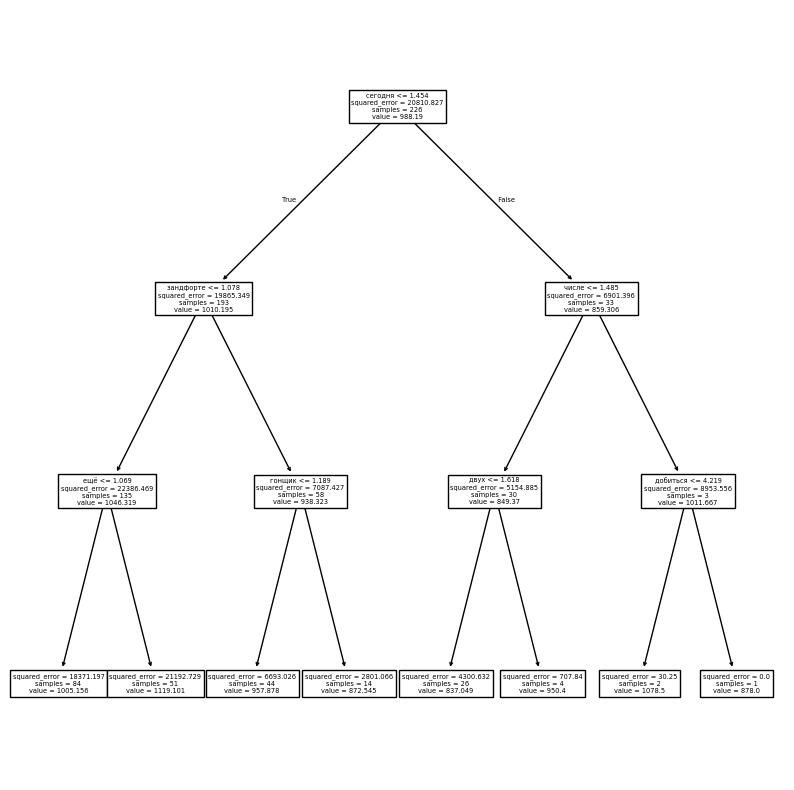

In [103]:
from sklearn import tree
import matplotlib.pyplot as plt

fn = vectorizer.get_feature_names_out()
plt.figure(figsize=(10, 10))
tree.plot_tree(
    model.estimators_[0],
    feature_names=fn,
);

Как видно, в текущем дереве наиболее важный токен - "сегодня". Так же в дерево вошли локации (зандворт) и слова "гонщик", "добиться"